# Overview

This notebook give an overview of geosocial media and other UGGC collection for Melbourne. It adapts various notebooks from different projects.  

Requirements: 
- Accounts and API keys to authenticate to the platforms (removed from the code below)
- Libraries to access APIs from Python (usually easy by calling "pip install libraryname" or "conda install libraryname" from the command line
- (Optional) PostGIS database to store data
- (Optional) GIS to view data

## OSM base data
There are many ways to get base data and load it in a GIS. One easy way is to follow the tutorial at http://learnosm.org/en/osm-data/osm-in-qgis/ and import OSM into QGIS. 

## Flickr
### Bounding box
First step is to decide on a bounding box for Melbourne. Although there are multiple ways of deriving a bounding box from different sources, using the bounding box derived from Twitter seems the most straightforward and sufficient. 

Of course, it is always strongly recommended to check any results. Although plotting the results directly in this notebook via mathplotlib is possible, exporting the data and using a full-fledged GIS (QGIS) gives more flexibility for interactve visual exploratory analysis.  

In [2]:
import twitter

CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''
auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)    
twitter_api = twitter.Twitter(auth=auth)

In [8]:
# actually cheating, because first looked up coordinates via Geonames...
print (twitter_api.geo.search(query="Melbourne", granularity="city", lat="-37.8142176",lon="144.9631608"))

{'result': {'places': [{'id': '01864a8a64df9dc4', 'url': 'https://api.twitter.com/1.1/geo/id/01864a8a64df9dc4.json', 'place_type': 'city', 'name': 'Melbourne', 'full_name': 'Melbourne, Victoria', 'country_code': 'AU', 'country': 'Australia', 'contained_within': [{'id': '0ec0c4fcacbd0083', 'url': 'https://api.twitter.com/1.1/geo/id/0ec0c4fcacbd0083.json', 'place_type': 'admin', 'name': 'Victoria', 'full_name': 'Victoria, Australia', 'country_code': 'AU', 'country': 'Australia', 'centroid': [144.54967312500384, -36.55858281222535], 'bounding_box': {'type': 'Polygon', 'coordinates': [[[140.961681976682, -39.1591895298437], [140.961681976682, -33.9804255797424], [149.976679007421, -33.9804255797424], [149.976679007421, -39.1591895298437], [140.961681976682, -39.1591895298437]]]}, 'attributes': {}}], 'centroid': [145.15252939909652, -37.972566514250005], 'bounding_box': {'type': 'Polygon', 'coordinates': [[[144.593741856, -38.433859306], [144.593741856, -37.5112737225], [145.512528832, -37.

### Querying the API
First load core search script, then add variables. Watch our for lat/lon order, and always do a check before starting big queries! Also, for bigger queries that take hours, using an IDE is recommended because Jupyter notebook becomes unresponsive.  

In [14]:
#!/usr/bin/python

"""
Modified on 2018-01-30

@author: OstermannFO

flickrdatacollection_searchAPI.py: 
    access FlickrAPI
    write metadata as in text file
    
code not fully tested for use with Python 3
code is not optimized for performance or brevity, 
aims instead for readability and ease of understanding 
"""

import flickrapi
import datetime
import time
import sys
import os
import io

#
# declare global USER variables
#

# output path (end with double backslash!) and file name trunk
PATH = 'C:\\path\\to\\working\\directory\\'
FILE_OUT_TRUNK = 'melbourne_geosafe_workshop'

# api_key
API_KEY = ''
API_SECRET = ''

# define search query keywords, dates and location;
# dates should be as 'YYYY-MM-DD'
# radius unit is km, default is 5
# bounding box min_lon, min_lat, max_lon, max_lat
SEARCH_QUERY = ''
START_DATE = '2018-01-20'
END_DATE = '2018-01-21'
LAT = ''
LON = ''
RADIUS = '' 
BBOX = '144.593741856, -38.433859306, 145.512528832, -37.5112737225' 

# define search extras to be retrieved
SEARCH_EXTRAS = 'date_taken, date_upload, description, owner_name, geo, tags'

# flow control for this script
# tags_raw = 'yes' if raw tags should be retrieved; however, this makes 
# execution much slower; since queries do not return all photos all the time 
# (Flickr API bug), queries with large results sets might not want to use this 
# count_only = 'yes' to execute only initial query returning number of photos
TAGS_RAW = 'yes' 
COUNT_ONLY = 'no'

# list of values to be written to file
# owner_subelements_list currently not used
PHOTO_ATTR_LIST = ['id', 'title', 'owner', 'ownername', 'datetaken', 'dateupload', 'latitude', 'longitude', 'accuracy', 'tags']
PHOTO_SUBELEM_LIST = ['description']
#owner_subelements_list = ['realname', 'location'] 

# replace all problematic characters in the retrieved text
def replace_chars(text):
        text = text.replace('\r',' ')\
                    .replace('\n', ' ')\
                    .replace('\t', ' ')\
                    .replace(',', ' ')\
                    .replace("'", " ")\
                    .replace('"', ' ')\
                    #.replace('\\','/') #this one might clash with unicode
        return text
 
# search if bounding box is given
def search_latlonrad(flickr,min_taken_date,max_taken_date,page):
    search_results = flickr.photos_search(
                text = SEARCH_QUERY,
                min_taken_date = min_taken_date,
                max_taken_date = max_taken_date,
                extras = SEARCH_EXTRAS,
                lat = LAT,
                lon = LON,
                radius = RADIUS, 
                page = page)
    return search_results            

# search if lat/lon and radius are given
def search_bbox(flickr,min_taken_date,max_taken_date,page):
    search_results = flickr.photos_search(
                text = SEARCH_QUERY,
                min_taken_date = min_taken_date,
                max_taken_date = max_taken_date,
                extras = SEARCH_EXTRAS,
                bbox = BBOX,
                page = page)        
    return search_results

def main():    
    # create flickr instance
    flickr = flickrapi.FlickrAPI(API_KEY, API_SECRET)
    flickr.authenticate_via_browser(perms='read')

    # get total number of search results
    # cannot use lat/lon/radius with an empty bbox, therefore IF-THEN
    if BBOX == '':
        search_results = search_latlonrad(flickr,START_DATE,END_DATE,0)
    else:
        search_results = search_bbox(flickr,START_DATE,END_DATE,0)
    
    photos_query_total = search_results.find('photos').get('total')
    print ("Total number of photos according to API: " + str(photos_query_total))
    
    if COUNT_ONLY == 'yes':    
        sys.exit("exiting...")
    
    # create new directory if necessary and write meta data to info file
    new_dir = "%s%s\\" %(PATH, FILE_OUT_TRUNK)
    if not os.path.exists(new_dir):
        try: 
            os.makedirs(new_dir)
        except: 
            print ("Could not create new directory!")
            sys.exit()
    
    # info file on search query
    f_info=open(new_dir + FILE_OUT_TRUNK + "_info.txt", encoding = "utf-8", mode = "w")
    f_info.write('query_time, query, start_date, end_date, lat, lon, bbox,'\
                 ' extras, raw_tags, number_of_photos,'\
                 ' counted, ignored, processed\n')
    
    header = ""
    for column in PHOTO_ATTR_LIST:
        header += column + '\t'
    header += 'tags_raw\t'
    for column in PHOTO_SUBELEM_LIST:
        header += column + '\t'
    #for column in owner_subelements_list:
    #    header += column + '\t'
    header = header.rstrip('\t')
    
    # start actual retrieval of data
    # first convert query dates to integer
    start_iter = datetime.datetime.strptime(START_DATE,"%Y-%m-%d").toordinal()
    end_iter = datetime.datetime.strptime(END_DATE,"%Y-%m-%d").toordinal()
    
    # initiate counters and list to filter out duplicates
    counter = 0
    ignored = 0
    processed = 0
    fid_list = []
    
    # end_iter +1 needed to get last day
    for i in range (start_iter, end_iter+1):
        
        print ("day ",str(i), end = " "),
        
        # open daily output file
        query_date = datetime.date.fromordinal(i)
        f_results = open(new_dir + FILE_OUT_TRUNK + "_" + 
                         str(query_date) + ".tsv", encoding = "utf-8", mode = 'w')
        f_results.write(header + "\n")
    
        # using single days +-1 retrieves more reliable results
        min_query_date = datetime.date.fromordinal(i-1)
        max_query_date = datetime.date.fromordinal(i+1)        
        if BBOX == '':
            search_results_daily = search_latlonrad(flickr,min_query_date,max_query_date,0)
        else:
            search_results_daily = search_bbox(flickr,min_query_date,max_query_date,0)
        
        # to avoid rate limits, wait one second after api call
        time.sleep(1)
        
        # iterate over pages; it is possible to specify number of photos per 
        # page, but it does not change maximum number of photos per query
        # (always 4000); therefore best to leave it at default (100 photos per page)
        print (" page ", end = " "),
        for i in range (int(search_results_daily.find('photos').get('pages'))+2):
            print (str(i), end = " ")
            # try statement needed because there occasional API errors
            try:
                if BBOX == '':
                    search_results_daily_paginated = search_latlonrad(
                            flickr,min_query_date,max_query_date, i)
                else:
                    search_results_daily_paginated = search_bbox(
                            flickr,min_query_date,max_query_date, i)
                                
                # to avoid rate limits, wait one second after api call
                time.sleep(1)
        
                # Iterate over photos in page
                photo_iter = search_results_daily_paginated.getiterator('photo')   
                for photo in photo_iter:
                    counter += 1
                    out_row = ""
                    try: 
                        fid = photo.get('id')
                        # check whether photo has already been processed
                        if fid in fid_list: 
                            ignored += 1
                            break
                        fid_list.append(fid)
                        #print (type(fid))
                        out_row = fid + '\t'             
                        #print ("outrow:", out_row)
                        for attribute in PHOTO_ATTR_LIST[1:]:                
                            value = photo.get(attribute)             
                            # convert datetaken into posix timestamp
                            if attribute == 'datetaken':
                                value = time.mktime(datetime.datetime.strptime(
                                        value, "%Y-%m-%d %H:%M:%S").timetuple())
                                out_row += str(int(value)) + '\t'
                            else:
                                if value is None:
                                    value = 'NODATA'
                                value = replace_chars(value)
                                out_row += value + '\t'
                        
                        if TAGS_RAW == 'yes':
                            raw_tags = ''
                            tags = flickr.tags_getlistphoto(photo_id = fid)
                            # no wait possible here, otherwise takes too long
                            tag_iter = tags.getiterator('tag')
                            if tag_iter is None:
                                raw_tags = 'NODATA'
                            for tag in tag_iter:
                                raw_tag = tag.get('raw')
                                raw_tag = replace_chars(raw_tag)
                                raw_tags += raw_tag + "~"
                            raw_tags = raw_tags.rstrip('~')
                        else: 
                            raw_tags = "NOTQUERIED"
                        out_row += raw_tags + '\t'
                            
                        for photo_subelement in PHOTO_SUBELEM_LIST:
                            value = photo.find(photo_subelement).text
                            if value is None:
                                value = 'NODATA'
                            else:
                                value = replace_chars(value)
                            out_row += value   
                        
                        f_results.write(out_row + '\n')
                        processed += 1
                    
                    except Exception as e: 
                        print ("Problem with photo", sys.exc_info()[0], str(e)," in line ", sys.exc_info()[-1].tb_lineno)
            
            except Exception as e:
                 print ("Problem with search page!", sys.exc_info()[0], str(e))
                                          
        print (query_date, photos_query_total, counter, ignored, processed)
        f_results.close()  
    
    f_info.write('{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                 datetime.date.today(),SEARCH_QUERY,START_DATE,
                 END_DATE,LAT,LON,BBOX,SEARCH_EXTRAS,TAGS_RAW,
                 photos_query_total, counter, ignored, processed))
    
    f_info.close()

if __name__=="__main__":
    main() 


Total number of photos according to API: 94
day  736714  page  0 1 2 
 2018-01-20 94 122 1 121
day  736715  page  0 1 2 
 2018-01-21 94 124 3 121


### Storing the output
The resulting tsv's can be easily loaded with QGIS for checking the bounding box. However, for a more sustainable and scalable solution, a DBMS is preferable. NoSQL databases are an option, but depending on the volume of data, one needs to take what is available at an institutional level. In this case, Postgresql/PostGIS. 

As with the previous script, first load the core script, then configure the variables and database parameters. 

In [18]:
#!/usr/bin/python

"""
Modified on 2018-01-30

@author: OstermannFO

FlickrParsingToPostgresql_London.py: 
    reads Flickr photo metadata line by line
    parses them and puts desired values in database
    
code not fully tested for use with Python 3
necessary to create INSERT INTO statement manually
"""

import psycopg2
import os
import sys
import datetime

#
#declare variables
# 

CONN_DB = ""
PATH = 'C:\\path\\to\\working\\directory\\'
IN_FILE_EXT = ".tsv" 
LOG_FILE_NAME = "melbourne.log"

def main():
    conn=psycopg2.connect(CONN_DB)
    cur=conn.cursor()
    
    log_file = open(LOG_FILE_NAME,'a')
    
    for f in os.listdir(PATH):
        if f.endswith(IN_FILE_EXT):
            in_file_name = PATH + f
            in_file = open(in_file_name,encoding = "utf-8", mode = "r")
            print ("Now reading ... " + in_file_name)
            next(in_file)
            
            for line in in_file:
                
                try:
                    fields = line.split('\t')                   
                    fid = fields[0]
                    title = fields[1]
                    uid = fields[2]
                    uname = fields[3]
                    date_up = fields[4]
                    date_taken = fields[5]
                    lat = fields[6]
                    lon = fields[7]
                    acc = fields[8]
                    tags_flickr = fields[9]
                    tags_user = fields[10]
                    descr = fields[11]
    
                    data = (fid,title,uid,uname,date_up,date_taken,lat,lon,
                            acc,tags_flickr,tags_user,descr,)
                    
                    try: 
                        
                        cur.execute(
                            """INSERT INTO fo.melb_flickr_geo (FID,TITLE,UID,UNAME,
                            DATE_UP,DATE_TAKEN,LAT,LON,ACC,
                            TAGS_FLICKR,TAGS_USER,DESCR) VALUES 
                            (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);
                            """, data)
                        conn.commit()
                        
                    except Exception as e:
                        conn.rollback()
                        print ("DB Error: ", sys.exc_info()[0], e)
                        log_file.write(str(datetime.datetime.today()) 
                                       + " DB Error in " + in_file_name 
                                       + " with flickr_id " + fid + " : " 
                                       + str(e).replace("\n"," ") + "\n")
                    
                except Exception as e:
                    print ("Other Error: ", sys.exc_info()[0], e)
                    log_file.write(str(datetime.datetime.today()) 
                                    + " Other Error in " + in_file_name 
                                    + " with flickr_id " + fid + " : " 
                                    + str(e).replace("\n"," ") + "\n")
            in_file.close()
    
    cur.execute("""UPDATE fo.melb_flickr_geo SET the_geom = ST_SetSRID(
            ST_Point(lon,lat),4326) WHERE the_geom IS NULL""")
    conn.commit()
    conn.close()
    log_file.close()

if __name__=="__main__":
    main() 

Now reading ... C:\Users\OstermannFO\Downloads\flickr_tmp\melbourne_2018\melbourne_2018_2018-01-01.tsv
DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(28045401999) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39114319354) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39082848864) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38893910575) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39048618844) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate ke

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38590181255) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27691647679) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27691646869) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27691645369) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38590176105) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38590175355) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38565639125) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(25574293278) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38565637525) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38565637455) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38565636545) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38736142034) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39407869861) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27630576169) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39377777872) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24542117867) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24542115917) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39407853341) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24724424887) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38883583144) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39591847431) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39591838421) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38696012535) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39591814271) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39433835632) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39433770742) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(25593953718) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39433656982) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24596020007) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24595247587) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39447094881) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38738878404) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39416199992) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38568394825) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39444924411) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38566409045) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39530562072) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39530537332) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27783700739) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38851063814) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24692494007) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(25689792928) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39514113191) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38617366025) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38803799834) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38803794974) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38803791744) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(38803788144) already e

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27808902139) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39545803642) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39545802312) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39545801652) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27795270699) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27794978919) already e

Now reading ... C:\Users\OstermannFO\Downloads\flickr_tmp\melbourne_2018\melbourne_2018_2018-01-13.tsv
DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39752630581) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(24881372877) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39750988841) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(27939967689) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate key value violates unique constraint "melb_flickr_geo_fid_key"
DETAIL:  Key (fid)=(39718983041) already exists.

DB Error:  <class 'psycopg2.IntegrityError'> duplicate ke

### Some exploratory analysis
Using pandas, numpy, matplotlib. 

In [19]:
import pandas
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

CONN_DB = ""
conn=psycopg2.connect(CONN_DB)
df = pandas.read_sql_query('select * from fo.melb_flickr_geo',con=conn)
conn.close()
list(df.columns.values)

['gid',
 'fid',
 'acc',
 'lon',
 'lat',
 'uid',
 'title',
 'date_up',
 'date_taken',
 'descr',
 'tags_user',
 'tags_flickr',
 'the_geom',
 'tv_acti',
 'tv_elem',
 'tv_qual',
 'terms_found',
 'uname']

In [20]:
df['uname'].value_counts()

Michael  Comeng301M  Coley                     8308
louisa_catlover                                6857
dok1969                                        6622
Scootie                                        5681
Steven Taylor (Aust)                           5528
Quick Shot Photos                              5486
williewonker                                   5408
melbournian1                                   4976
JVinOZ                                         4443
shopsui                                        4429
Biker Jun                                      4380
odeliagardens                                  3990
Hunter G 1                                     3847
yewenyi                                        3644
ajhaysom                                       3547
MU Athletics Club                              3104
john.gollings                                  2906
Andrew Y2010                                   2865
art.thai                                       2826
Naomi Rahim 

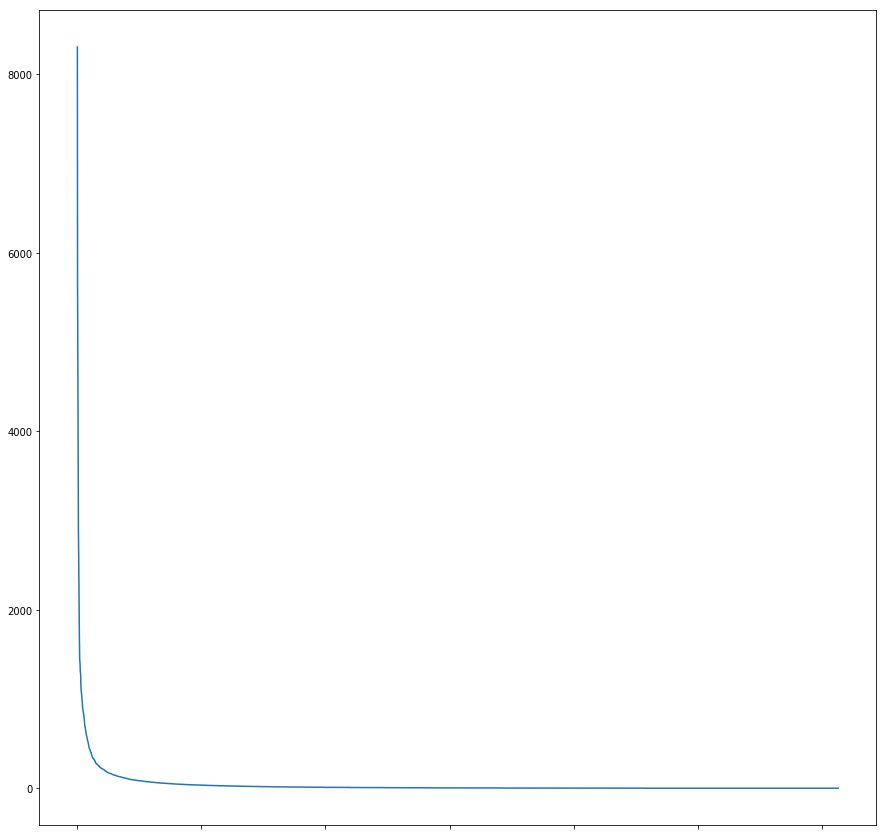

In [21]:
df['uname'].value_counts().plot(figsize=(15,15))

In [26]:
import datetime

print (df['date_taken'].min(), datetime.datetime.fromtimestamp(df['date_taken'].min()))
print (df['date_taken'].max(), datetime.datetime.fromtimestamp(df['date_taken'].max()))

1089577299 2004-07-11 22:21:39
1516695641 2018-01-23 09:20:41


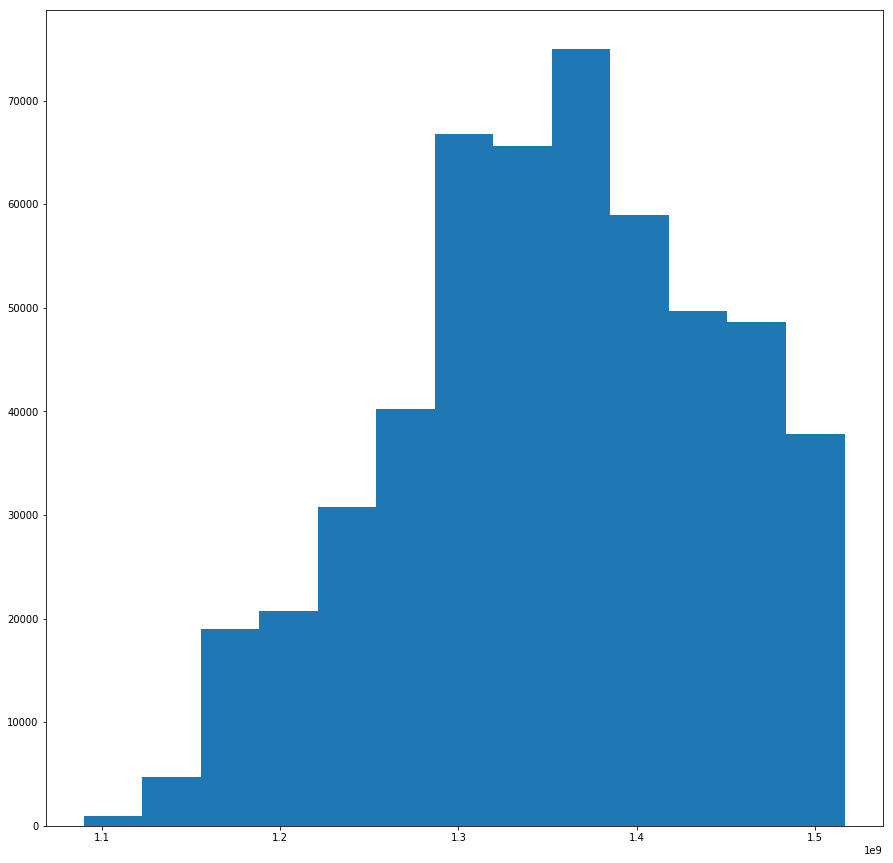

In [23]:
plt.figure(2,figsize=(15,15))
plt.hist(df['date_taken'], bins = 13)
plt.show()

### Some clustering (DBSCAN)
Note that the parameters do not make sense here - it is just for illustration. 

52 53 10000


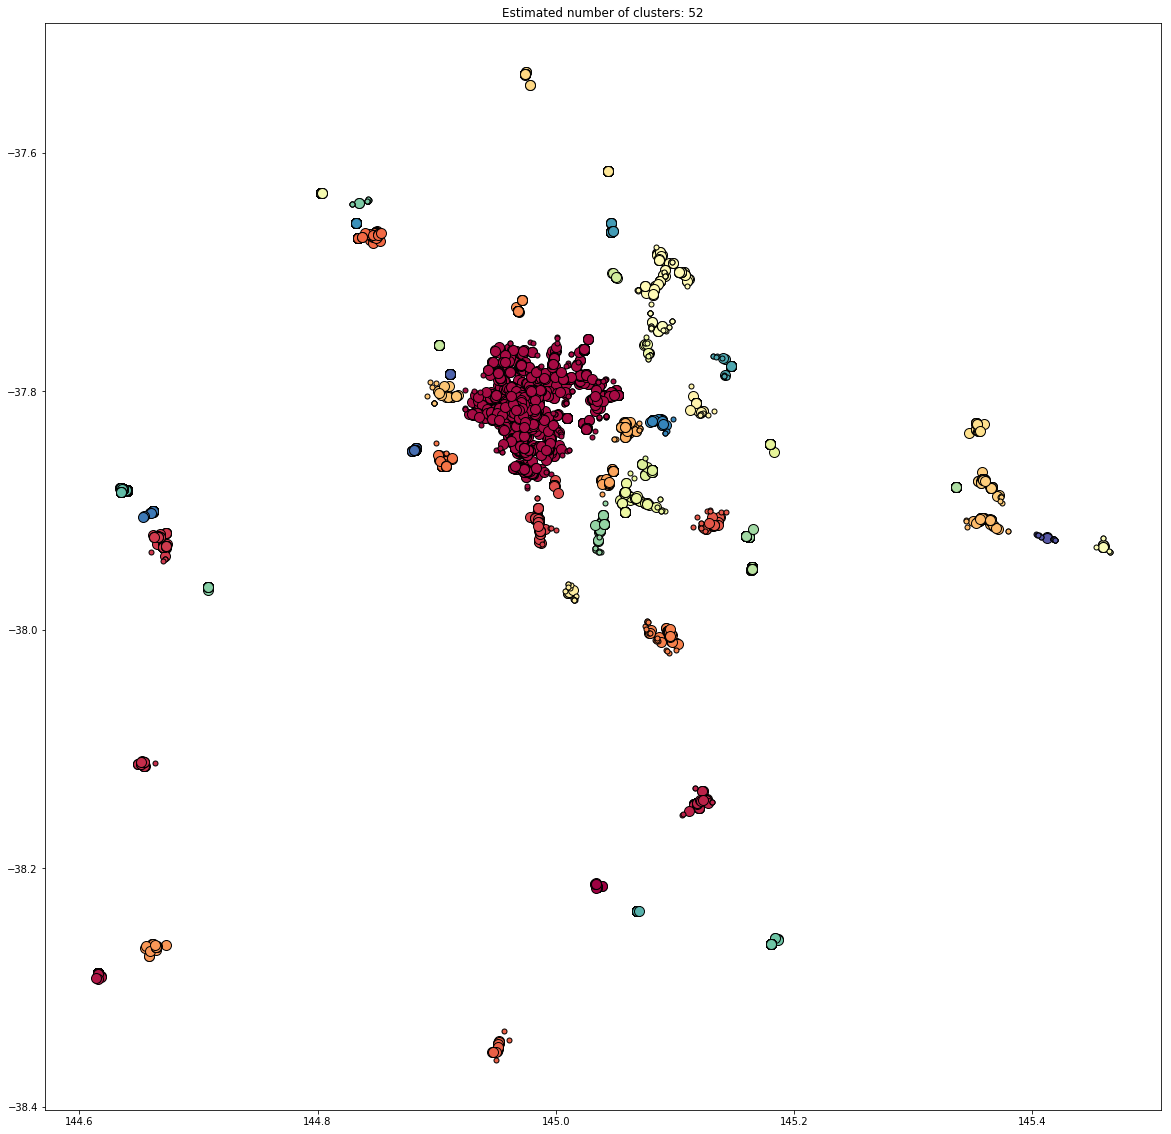

In [29]:
from sklearn.cluster import DBSCAN

# reduce size of dataset
X = df.values[:10000,[3,4]]

# Compute DBSCAN
db = DBSCAN(eps=0.01, min_samples=20).fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print (n_clusters_, len(set(labels)), len(labels))

# Plot result
plt.figure(3,figsize=(20,20))


core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        #skip showing noise
        continue

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Twitter
Only demo. 

In [36]:
#!/usr/bin/python

"""
Modified on 2018-01-30

@author: OstermannFO

twitterdatacollection_searchAPI.py: 
    access TwitterSeachAPI
    write Tweets as JSON objects in text file

Python 3 unicode character treatment not validated
"""

import twitter
import io
import json
import time
from urllib.parse import unquote

# set query parameters
QUERY = '' #Comma-separated list of terms
GEOCODE = '-37.8142176,144.9631608,10km' #latitude, longitude, radius, e.g. 52.000000,5.500000,250km
UNTIL = '' # e.g. 2017-04-01
MAX_RESULTS = 100

# set path to output files
OUTPUT_PATH = 'C:\\path\\to\\working\\directory\\'

# add authentification details 
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''
    
def oauth_login():   
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

def twitter_search(twitter_api, q, max_results=200, **kw):
    search_results = twitter_api.search.tweets(q=q, count=100, **kw)
    statuses = search_results['statuses']
    max_results = min(1000, max_results)
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
        print (next_results)    
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
            for kv in unquote(next_results[1:]).split("&") ])
        #print kwargs
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']               
    return statuses
    
def save_json(filename, data):    
    with io.open('{}{}.txt'.format(OUTPUT_PATH, filename),
                 'a', encoding='utf-8') as f:
        f.write(json.dumps(data, ensure_ascii=False)+'\n')

def main():    
    twitter_api = oauth_login()          
    filename = time.strftime("%Y%m%d-%H%M%S")    
    results = twitter_search(twitter_api, QUERY, MAX_RESULTS, 
                             geocode=GEOCODE, until=UNTIL)
    for result in results:
        save_json(filename, result)
    #Show one sample search result by slicing the list...
    print (len(results))
    print (json.dumps(results[0], indent=1))

if __name__=="__main__":
    main()        

?max_id=958272485346037759&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958272333147459583&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958272188666101760&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958272025151225855&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271869295063040&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271696737218559&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271520718995455&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271375696846848&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271201939304447&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1
?max_id=958271054501302272&q=&geocode=-37.8142176%2C144.9631608%2C10km&count=100&include_entities=1


For larger datasets, best to parse and insert into a database. For this small dataset, we will parse and create a CSV that QGIS can read. 

In [37]:
import json
import os
import codecs
import sys
import csv

inpath = 'C:\\path\\to\\working\\directory\\'
outfile = 'C:\\path\\to\\working\\directory\\'

header = "tweet_id,tweet_text,tweet_created,tweet_lon,tweet_lat,user_id,user_name,user_folcount,user_statcount,user_descr,user_loc,place_name,place_id\n"

outfile_handle = open(outfile,'w')
outfile_handle.write(header)

csvout = csv.writer(outfile_handle)

for f in os.listdir(inpath):
    if f.endswith(".txt"):
        twitter_file = open(inpath+f,'r')
        print ("Now reading ... " + str(f))
        try:
            for line in twitter_file:
                try:
                    Tweet = json.loads(line)
                    tweet_id=str(Tweet['id'])
                    tweet_text=Tweet['text']
                    tweet_created=Tweet['created_at']
                    if Tweet['coordinates']:
                        tweet_lon=str(Tweet['coordinates']['coordinates'][0])
                        tweet_lat=str(Tweet['coordinates']['coordinates'][1])
                    else:
                        tweet_lon=None
                        tweet_lat=None
                    user_id=Tweet['user']['id_str']
                    user_name=Tweet['user']['screen_name']
                    user_folcount=str(Tweet['user']['followers_count'])
                    user_statcount=str(Tweet['user']['statuses_count'])
                    user_descr=Tweet['user']['description']
                    user_loc=Tweet['user']['location']
                    if Tweet['place']:
                        place_name=Tweet['place']['full_name']
                        place_id=Tweet['place']['id']
                    else:
                        place_name=None
                        place_id=None
                    rowout = [tweet_id,tweet_text,tweet_created,
                              tweet_lon,tweet_lat,user_id,user_name,
                              user_folcount,user_statcount,user_descr,user_loc,
                              place_name,place_id]
                    csvout.writerow(rowout)
                except Exception as e:
                    print ("Something wrong with Tweet!", sys.exc_info()[0], str(e))
        except Exception as e:
            print ("Unexpected error, skipped!", sys.exc_info()[0], str(e), line[:40])
        twitter_file.close()
    else:
        continue
        
outfile_handle.close()


Now reading ... 20180123-203123.txt
Unexpected error, skipped! <class 'UnicodeDecodeError'> 'charmap' codec can't decode byte 0x9d in position 658: character maps to <undefined> {"contributors": null, "truncated": fals
Now reading ... 20180130-103503.txt
Now reading ... 20180130-103535.txt
Unexpected error, skipped! <class 'UnicodeDecodeError'> 'charmap' codec can't decode byte 0x81 in position 123: character maps to <undefined> {"contributors": null, "truncated": fals
Now reading ... 20180130-103631.txt
Unexpected error, skipped! <class 'UnicodeDecodeError'> 'charmap' codec can't decode byte 0x8f in position 5148: character maps to <undefined> {"created_at": "Tue Jan 30 09:36:13 +000


Lots of unicode errors! Hurray! In this case, it happens when the csv is written. Always check that the generated output is what you expect!

However, if we look at the remaining output, there is another problem: Twitter returned a lot of Tweets (actually the majority) that does not have an coordinates. That is because a geo-query also returns Tweets that have a place of which the bounding box intersects with the query. Or not even that. 

Location is mysterious in Twitter, and coordinates != place

## Foursquare
The following is based on the information contained in the Foursquare API and the Python wrapper documentation. https://developer.foursquare.com/start/search

https://github.com/mLewisLogic/foursquare

It seems that the most suitable method is search, which does not require user authentification: https://developer.foursquare.com/docs/venues/search

Objective: do a simple query for coffee shops (the Australian kind) in the center of Melbourne. 

In [39]:
import foursquare
import csv

client = foursquare.Foursquare(client_id='',
                               client_secret='')

venues = client.venues.search(params={'query': 'coffee', 'll': '-37.8142176,144.9631608'})
print (venues)

{'venues': [{'id': '555172a1498e9085353cce04', 'name': 'Hash Specialty Coffee', 'contact': {'twitter': 'hashroasters', 'facebook': '451959578306837', 'facebookUsername': 'hashcoffeeroasters', 'facebookName': 'Hash Specialty coffee & roasters'}, 'location': {'address': '113 Hardware St', 'lat': -37.8122308366527, 'lng': 144.96057126569383, 'labeledLatLngs': [{'label': 'display', 'lat': -37.8122308366527, 'lng': 144.96057126569383}], 'distance': 317, 'postalCode': '3000', 'cc': 'AU', 'city': 'Melbourne', 'state': 'VIC', 'country': 'Australia', 'formattedAddress': ['113 Hardware St', 'Melbourne VIC 3000', 'Australia']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'checkinsCount': 946, 'usersCount': 623, 'tipCount': 14}, 'allowMenuUrlEdit': True, 'beenHere': {'lastCheckinExpiredAt': 0}, '

This doesn't look very nice, let's save it as nice csv which then can be imported to QGIS.

In [46]:
with open('Melbourne_test_foursquare.csv', encoding = 'utf-8', mode = 'w', newline = '') as csvout:
        filewriter = csv.writer(csvout)
        fields = ['vid', 'name', 'lat', 'lon', 'category']
        filewriter.writerow(fields)
        place_ids = []
        for venue in venues['venues']:
            if venue['id'] not in place_ids:
                name = venue['name']
                vid = venue['id']
                lat = venue['location']['lat']
                lon = venue['location']['lng']
                place_ids.append(vid)
                try:
                    category = venue['categories'][0]['shortName']
                except IndexError: 
                    category =''
                rowout = [vid, name, lat, lon, category]
                filewriter.writerow(rowout)
            